We extract the data from the web using an API

In [59]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "5fdymyZntjECVai1ZmolqKBeG")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000) #"rk5x-gny6" esto es de la base de datos

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

In [61]:
#Check columns
comp.columns

Index(['any', 'codi_alumne', 'pcat', 'pcat_cl', 'pcat_ee', 'pcast', 'pcast_cl',
       'pcast_ee', 'pmat', 'pmat_nc', 'pmat_efm', 'pmat_cr', 'pang', 'pang_co',
       'pang_ce', 'pang_ee', 'pcat_co', 'pcast_co', 'pmed', 'pmed_comp1',
       'pmed_comp2', 'pmed_comp3', 'genere', 'mes_naixement', 'any_naixement',
       'area_territorial', 'naturalesa', 'h_bitat', 'pfran', 'pfran_co',
       'pfran_ce', 'pfran_ee'],
      dtype='object')

In [62]:
columns =['codi_alumne','pcat', 'pcat_cl', 'pcat_ee', 'pcast', 'pcast_cl',
       'pcast_ee', 'pmat', 'pmat_nc', 'pmat_efm', 'pmat_cr', 'pang', 'pang_co',
       'pang_ce', 'pang_ee', 'pcat_co', 'pcast_co', 'pmed','any']

In [63]:
#Select columns I want and dropna
comp = comp[columns]
comp_nomed = comp.copy()
comp = comp.dropna()
comp['any'].unique()

array(['2023', '2022', '2021', '2019', '2018'], dtype=object)

In [64]:
# Checked repeated codes
repeated = comp['codi_alumne'].value_counts()
no_unique = repeated[repeated > 1].index
unique = repeated[repeated == 1]
# The maximum repetition is two

El que vull primer és trobar una separació d'assignatures segons les intell·ligències múltiples, tenir una agrupació i llavors hauré de fer la mitjana per alumne de la nota en les diferents assignatures. Llavors hauré de trobar una manera de mirar les diferències.
* Lingüística: PCAT, PCAST, PANG
* Lògico-matemàtica: PMAT_NC, PMAT_CR
* Naturalista: PMED
* Espaial: PMAT_EFM


In [65]:
#Make sure columns are numerical
col_num = ['pcat', 'pcast', 'pang', 'pmat_nc', 'pmat_efm', 'pmat_cr', 'pmed','pmat']
col_nomed = ['pcat', 'pcast', 'pang', 'pmat_nc', 'pmat_efm', 'pmat_cr','pmat']

comp[col_num] = comp[col_num].apply(pd.to_numeric, errors='coerce')
comp_nomed[col_nomed] = comp_nomed[col_nomed].apply(pd.to_numeric, errors='coerce')

# Drop nan
comp = comp.dropna(subset=col_num)
comp_nomed = comp_nomed.dropna(subset=col_num_nomed)

# Made the mean of marks for repeated student codes 
df_mean = comp.groupby('codi_alumne').agg({
    'pcat': 'mean',  
    'pcast': 'mean',
    'pang': 'mean',
    'pmat_nc': 'mean',
    'pmat_efm': 'mean',
    'pmat_cr': 'mean',
    'pmed': 'mean',
    'pmat': 'mean'
}).reset_index()

# Made the mean of marks for repeated student codes 
df_mean_nomed = comp.groupby('codi_alumne').agg({
    'pcat': 'mean',  
    'pcast': 'mean',
    'pang': 'mean',
    'pmat_nc': 'mean',
    'pmat_efm': 'mean',
    'pmat_cr': 'mean',
    'pmat': 'mean'
}).reset_index()

# Mostrar el resultat
print(df_mean)

       codi_alumne   pcat  pcast   pang  pmat_nc  pmat_efm  pmat_cr   pmed  \
0       1000028138  75.48  62.15  82.92    60.00      80.0    44.44  84.86   
1       1000039359  76.24  76.87  62.08    80.00      90.0   100.00  73.75   
2       1000051581  67.02  72.02  90.83    66.67      90.0    77.78  79.44   
3       1000062802  92.17  74.29  92.92    93.33      80.0   100.00  86.25   
4       1000073134  73.64  50.83  65.42    53.33      30.0    66.67  62.22   
...            ...    ...    ...    ...      ...       ...      ...    ...   
347411   999938155  93.84  95.78  97.92    93.33     100.0   100.00  81.81   
347412   999949376  93.51  85.35  83.75    93.33      90.0   100.00  82.64   
347413   999961597  64.47  73.31  70.83    40.00      70.0    88.89  58.89   
347414   999983151  87.35  91.24  88.75   100.00      80.0    77.78  94.44   
347415   999994373  69.57  48.89  46.67    46.67      40.0    55.56  46.53   

         pmat  
0       61.56  
1       90.50  
2       78.72  

## Prove division of multiple inteligences
Now I should check the scatter plot of different marks to check if they are related and correspond to the same multiple inteligence or if they are not correlated.

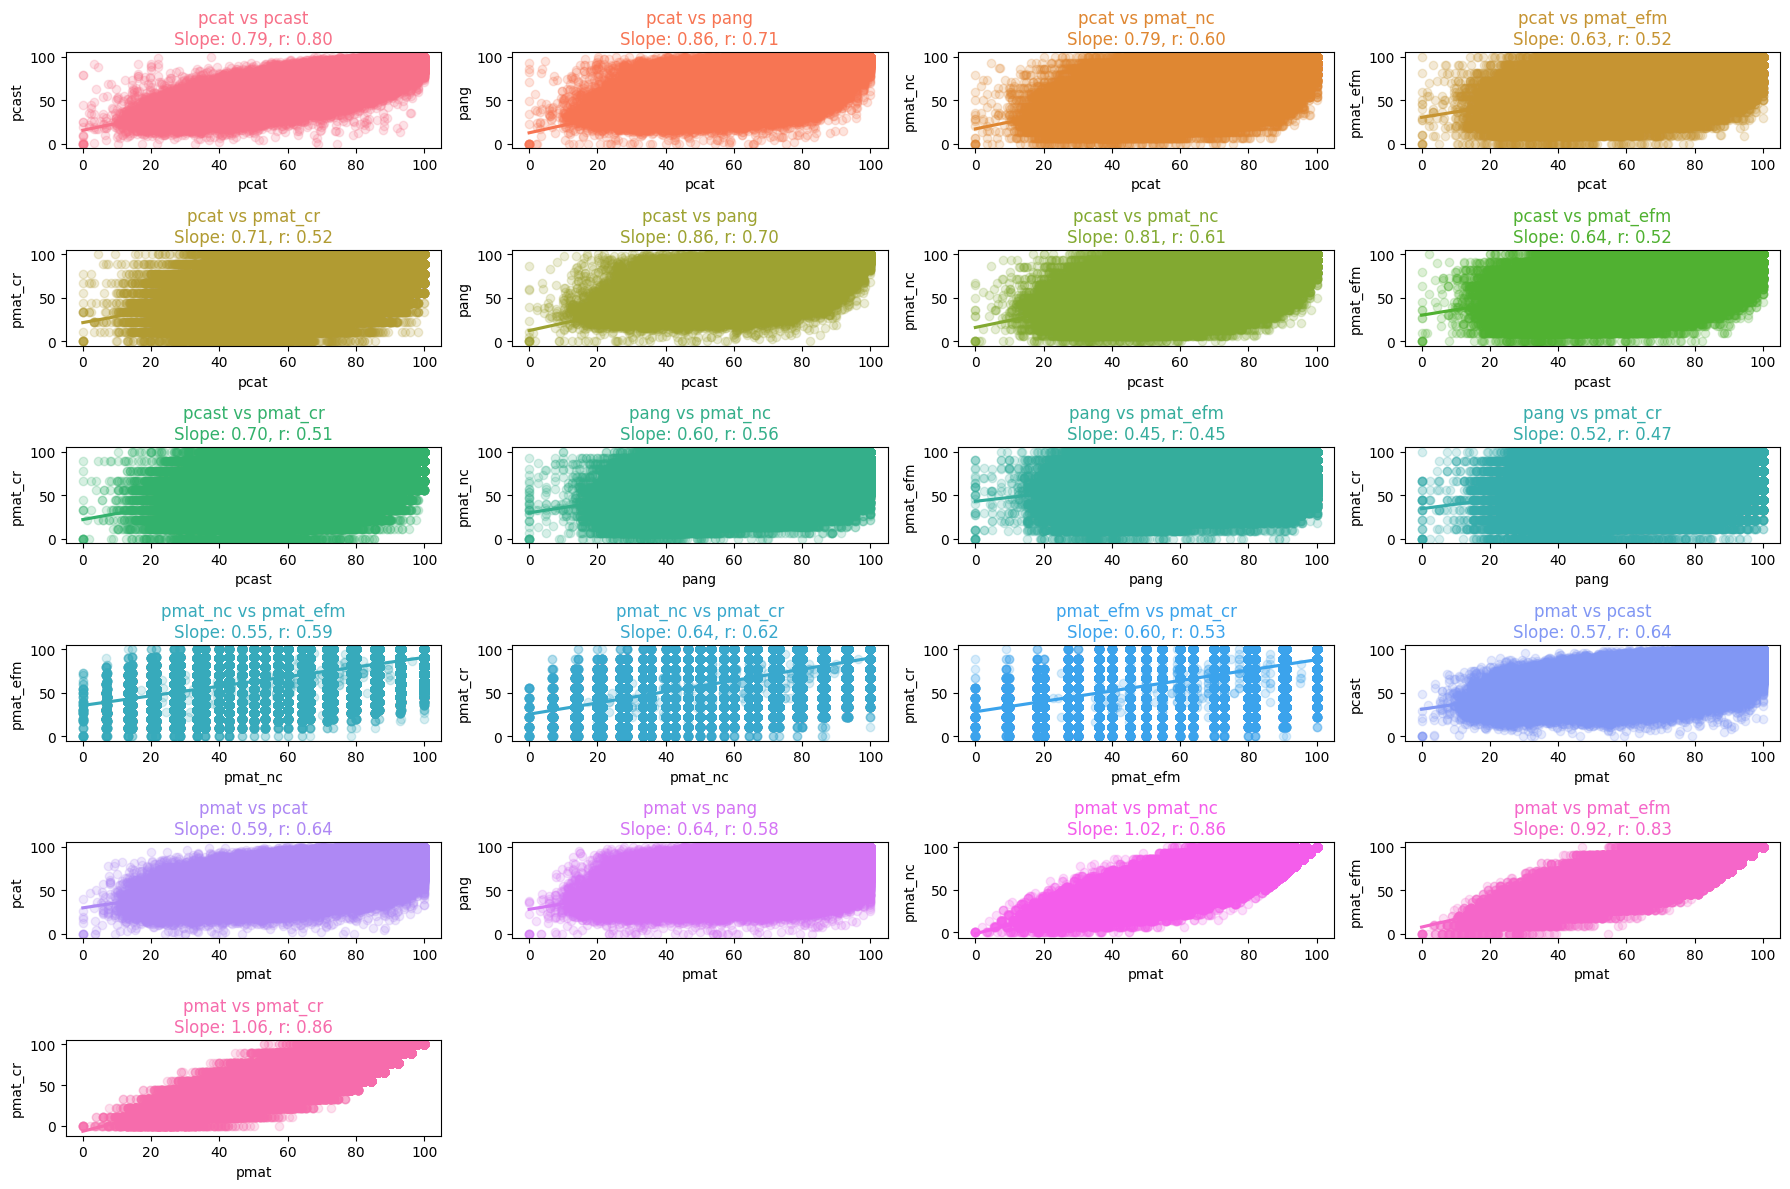

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import itertools

df = df_mean_nomed
# Generar totes les combinacions úniques de dues columnes (sense repetides)
combinations = [
    ('pcat', 'pcast'),
    ('pcat', 'pang'),
    ('pcat', 'pmat_nc'),
    ('pcat', 'pmat_efm'),
    ('pcat', 'pmat_cr'),
    ('pcast', 'pang'),
    ('pcast', 'pmat_nc'),
    ('pcast', 'pmat_efm'),
    ('pcast', 'pmat_cr'),
    ('pang', 'pmat_nc'),
    ('pang', 'pmat_efm'),
    ('pang', 'pmat_cr'),
    ('pmat_nc', 'pmat_efm'),
    ('pmat_nc', 'pmat_cr'),
    ('pmat_efm', 'pmat_cr'),
    ('pmat', 'pcast'),
    ('pmat', 'pcat'),
    ('pmat', 'pang'),
    ('pmat', 'pmat_nc'),
    ('pmat', 'pmat_efm'),
    ('pmat', 'pmat_cr')
]

# Configuració de la figura i subplots
n_plots = len(combinations)
n_cols = 4  # Número de columnes al panell
n_rows = -(-n_plots // n_cols)  # Calcula el número de files (divisió arrodonida cap amunt)
colors = sns.color_palette("husl", n_plots)  # Genera una paleta de colors

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Converteix en una llista plana per iterar fàcilment

# Crear scatter plots per a cada combinació
for ax, (x_col, y_col), color in zip(axes, combinations, colors):
    # Ajustar la regressió lineal amb SciPy
    slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
    
    # Crear el scatter plot i la línia de regressió
    sns.regplot(x=x_col, y=y_col, data=df, ax=ax, scatter_kws={'alpha':0.2}, color = color)
    
    # Afegir títol amb la pendent i el coeficient de correlació
    ax.set_title(f'{x_col} vs {y_col}\nSlope: {slope:.2f}, r: {r_value:.2f}', color=color)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
# Amagar els subplots buits (si en queden)
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Ajustar el disseny
plt.tight_layout()
plt.show()


## Discusió de gràfic
+ Les assignatures de llengües estan relacionades, tal i com jo havia pensat, en especial català i castellà.
+ El problema és que les puntuacions de matemàtiques no estan massa relacionades, la nota d'una no és preventiva fora dels que tenen un zero o els que tenen un 10.
+ Que puc fer? Podria mirar només uns alumnes, per exemple, mirar als que han tret menys notes en general o als que han tret millors notes, o als de notes intermitjanes.
+ Que puc fer? Estudiar als que tenen molt de contrast entre una nota mínima i màxima, i fer un heat map.
+ Hi ha relació entre mat nc i els idiomes i entre nc i cr, mat efm va una mica per separat.
+ pmat se porta d'una forma més decent tot i que no m'agrada que ni hi hagui relacions entre les parts.

In [51]:
# Aquí només agafem les columnes rellevants, incloent 'pmat' i excloent les parts desglossades de 'pmat'
df_mean_nomed['nota_mitjana'] = df_mean_nomed[['pcat', 'pcast', 'pang', 'pmat']].mean(axis=1)

# Ordenar el dataframe per la nova columna 'nota_mitjana'
df_mean_nomed = df_mean_nomed.sort_values(by='nota_mitjana', ascending=False)

# Calcular el nombre d'alumnes que corresponen al 10% del total
top_10_percent = int(len(df_mean_nomed) * 0.10)

# Obtenir el primer 10% segons les notes
df_top_10 = df_mean_nomed.head(top_10_percent)

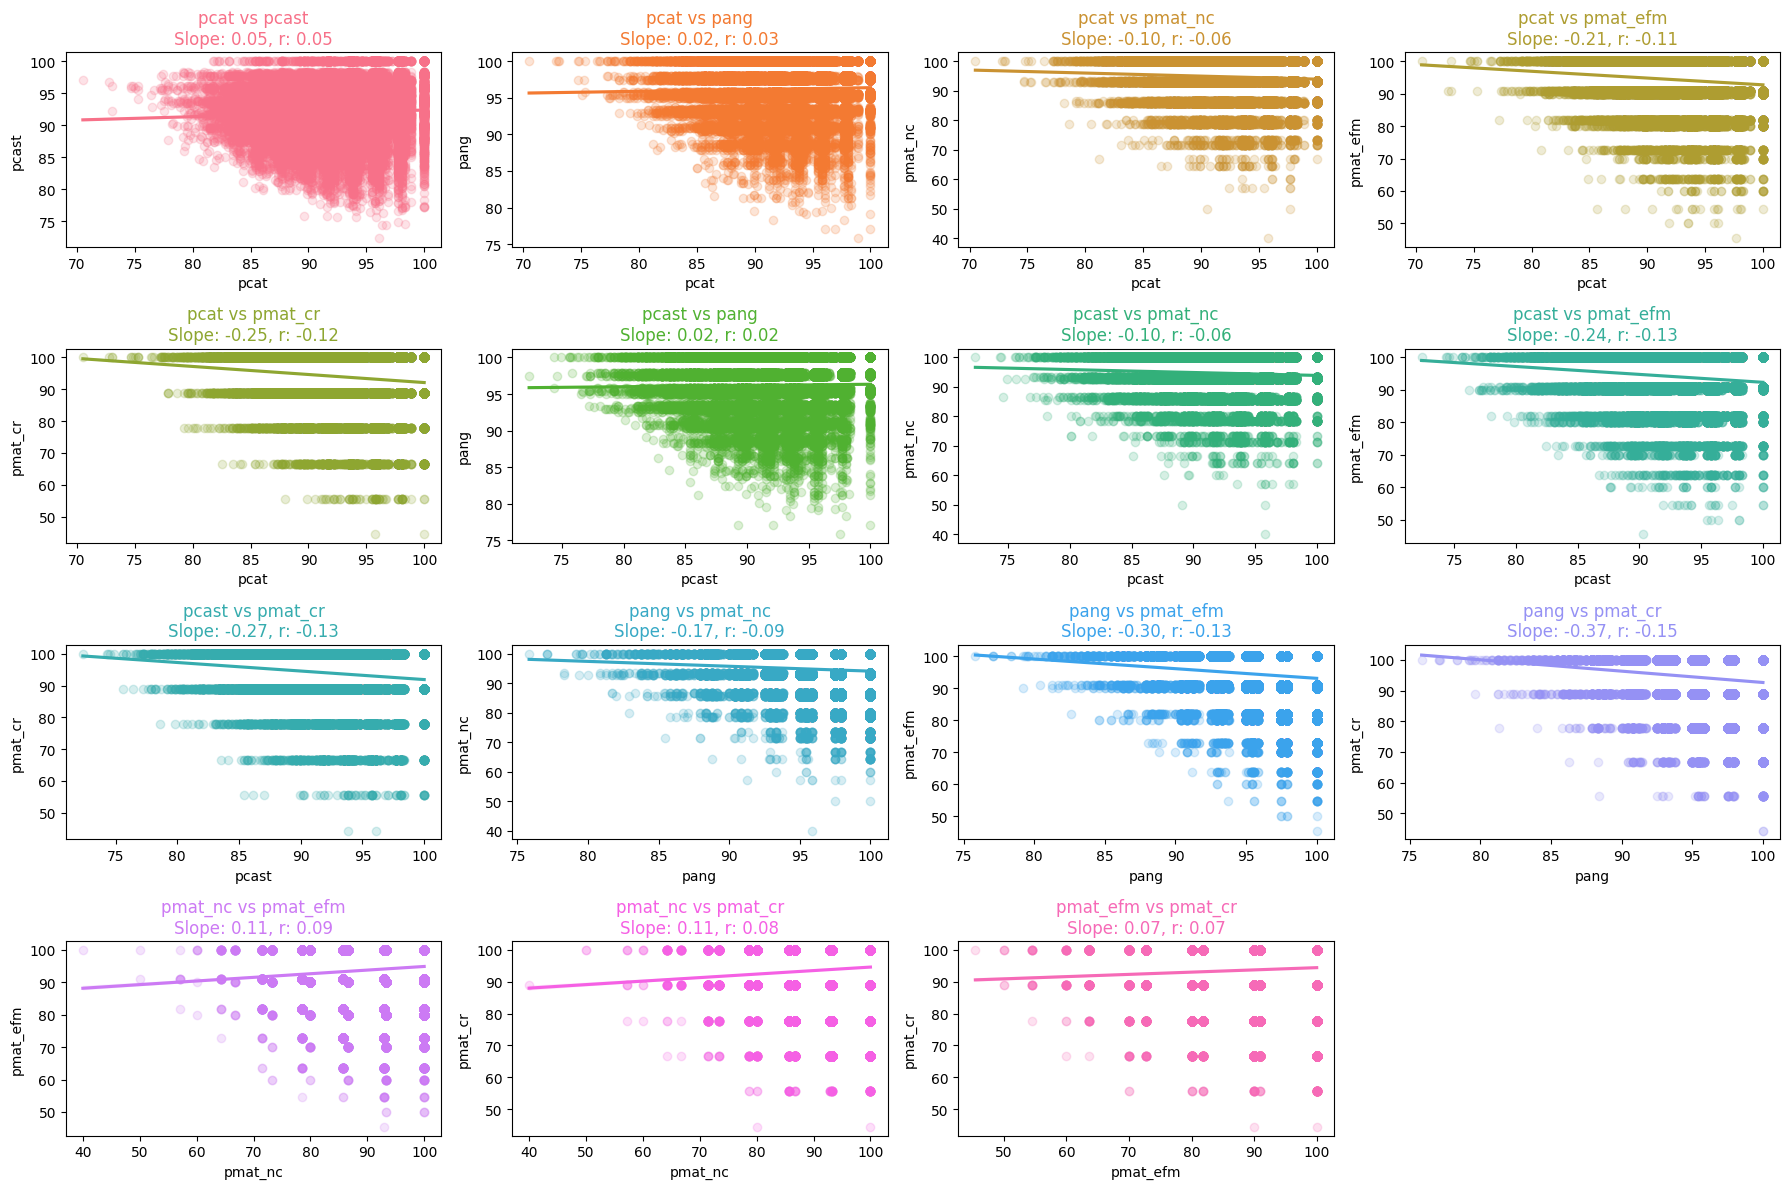

In [52]:
# Configuració de la figura i subplots
n_plots = len(combinations)
n_cols = 4  # Número de columnes al panell
n_rows = -(-n_plots // n_cols)  # Calcula el número de files (divisió arrodonida cap amunt)
colors = sns.color_palette("husl", n_plots)  # Genera una paleta de colors

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Converteix en una llista plana per iterar fàcilment

# Crear scatter plots per a cada combinació
for ax, (x_col, y_col), color in zip(axes, combinations, colors):
    # Ajustar la regressió lineal amb SciPy
    slope, intercept, r_value, p_value, std_err = linregress(df_top_10[x_col], df_top_10[y_col])
    
    # Crear el scatter plot i la línia de regressió
    sns.regplot(x=x_col, y=y_col, data=df_top_10, ax=ax, scatter_kws={'alpha':0.2}, color = color)
    
    # Afegir títol amb la pendent i el coeficient de correlació
    ax.set_title(f'{x_col} vs {y_col}\nSlope: {slope:.2f}, r: {r_value:.2f}', color=color)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
# Amagar els subplots buits (si en queden)
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Ajustar el disseny
plt.tight_layout()
plt.show()

El resultat és que els que tenen millors notes tampoc tenen una relació lineal, això vol dir que inclús en les assignatures més relacionades com català, castellà i anglès la relació és baixa amb aquest sentit. Hi ha com una variació aleatòria. Crec que estic perjudicant una mica les dades perquè en estar imposant que són les 10% millors notes, estic forçant a que els que trauen més males notes d'una assignatura, han de tenir prou bones en un altra. Pero no hi ha cap relació els que trauen molt bones notes, ho trauen de dos.

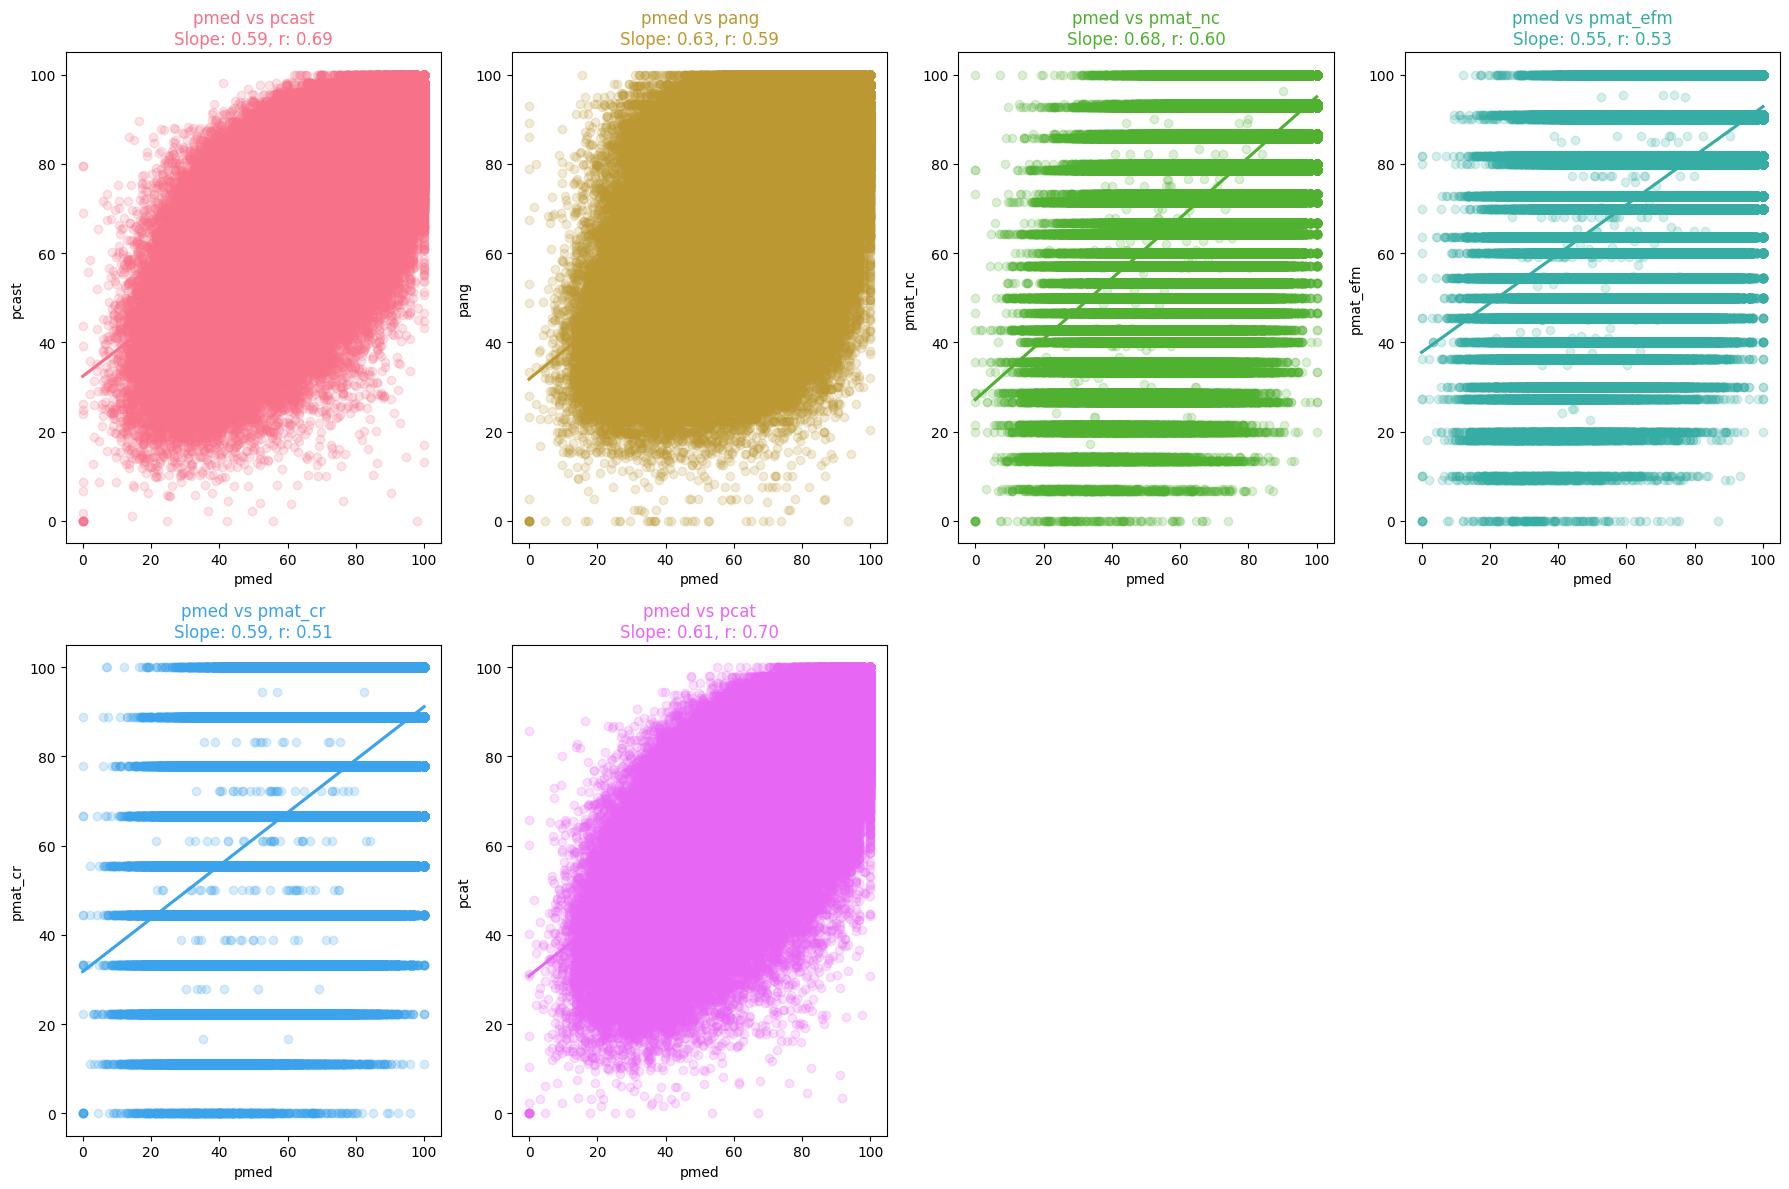

In [53]:
df = df_mean
combinations = [
    ('pmed', 'pcast'),
    ('pmed', 'pang'),
    ('pmed', 'pmat_nc'),
    ('pmed', 'pmat_efm'),
    ('pmed', 'pmat_cr'),
    ('pmed', 'pcat'),
]

# Configuració de la figura i subplots
n_plots = len(combinations)
n__cols = 4  # Número de columnes al panell
n_rows = -(-n_plots // n_cols)  # Calcula el número de files (divisió arrodonida cap amunt)
colors = sns.color_palette("husl", n_plots)  # Genera una paleta de colors

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Converteix en una llista plana per iterar fàcilment

# Crear scatter plots per a cada combinació
for ax, (x_col, y_col), color in zip(axes, combinations, colors):
    # Ajustar la regressió lineal amb SciPy
    slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
    
    # Crear el scatter plot i la línia de regressió
    sns.regplot(x=x_col, y=y_col, data=df, ax=ax, scatter_kws={'alpha':0.2}, color = color)
    
    # Afegir títol amb la pendent i el coeficient de correlació
    ax.set_title(f'{x_col} vs {y_col}\nSlope: {slope:.2f}, r: {r_value:.2f}', color=color)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
# Amagar els subplots buits (si en queden)
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Ajustar el disseny
plt.tight_layout()
plt.show()

## Que passa amb medi?
Tenim menys anys així que l'analitzo ara en comparació amb les altres assignatures. Lo que estic veient és que la prova de medi té més a veure en que entengues la llengua, sobretot en català i castellà que no una intel·ligència particular.

## I ara que miro?
+ Podria mirar que passa amb els de 4t de la eso?
+ Podria mirar que passa amb els millors de cada assignatura i amb els pitjors amb el heat map? Els millors en catala castella i angles, comparar amb els millors en les de matemàtiques.